## **Notebook 2 — Hypothesis Testing + Static Visuals (matplotlib, seaborn, plotly)**

**1. Imports & robust path resolution**

In [3]:
#Imports & path setup

import os
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Make plots look nice (optional)
sns.set(style="whitegrid", context="notebook")

# Resolve a robust path to your cleaned csv
# This tries common locations relative to the notebook's folder.
candidate_paths = [
    "../data/processed/spotify_clean.csv",
    "../data/spotify_clean.csv",
    "data/processed/spotify_clean.csv",
    "data/spotify_clean.csv",
]

clean_path = None
for p in candidate_paths:
    if os.path.exists(p):
        clean_path = p
        break

if clean_path is None:
    raise FileNotFoundError(f"Clean CSV not found. Tried: {candidate_paths}")

print("Using cleaned data from:", clean_path)


Using cleaned data from: ../data/processed/spotify_clean.csv


**2. Load data & quick checks**

In [4]:
# Load data & quick checks

df = pd.read_csv(clean_path)

# Overview to confirm structure and types
display(df.head())
df.info()

# Key columns we’ll use (some may be missing depending on your source)
needed = ["popularity","danceability","energy","valence","tempo","duration_ms",
          "explicit","track_genre","year"]
missing = [c for c in needed if c not in df.columns]
print("Missing (ok if not used later):", missing)

# Drop obvious duplicates by (track_name, primary_artist) if present
if {"track_name","primary_artist"}.issubset(df.columns):
    before = len(df)
    df = df.drop_duplicates(["track_name","primary_artist"])
    print(f"Deduplicated {before - len(df)} rows by (track_name, primary_artist)")



,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,liveness,valence,tempo,time_signature,track_genre,artists_list,primary_artist,n_artists,year,month
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0.3580,0.715,87.917,4,acoustic,['Gen Hoshino'],Gen Hoshino,1,NaN,NaN
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,0.1010,0.267,77.489,4,acoustic,['Ben Woodward'],Ben Woodward,1,NaN,NaN
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,0.1170,0.120,76.332,4,acoustic,"['Ingrid Michaelson', 'ZAYN']",Ingrid Michaelson,2,NaN,NaN
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,0.1320,0.143,181.740,3,acoustic,['Kina Grannis'],Kina Grannis,1,NaN,NaN
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,0.0829,0.167,119.949,4,acoustic,['Chord Overstreet'],Chord Overstreet,1,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

H1 - “Higher danceability and energy are associated with higher popularity.”

- We’re testing whether tracks that are more danceable and energetic tend to score higher on Spotify’s popularity metric (0–100).

- Plots used: Matplotlib scatter + line, Seaborn regplot, Plotly scatter (coloured by genre)




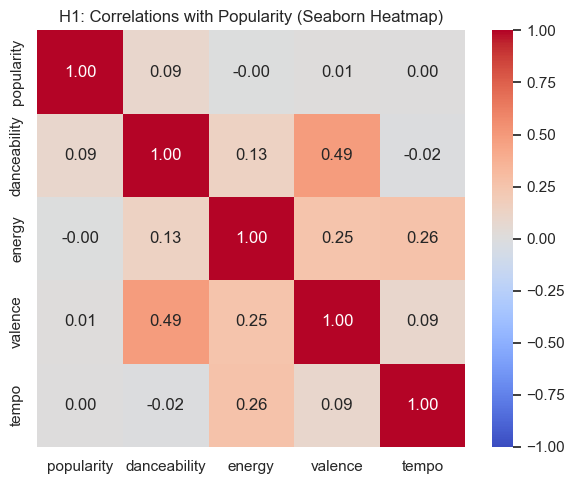

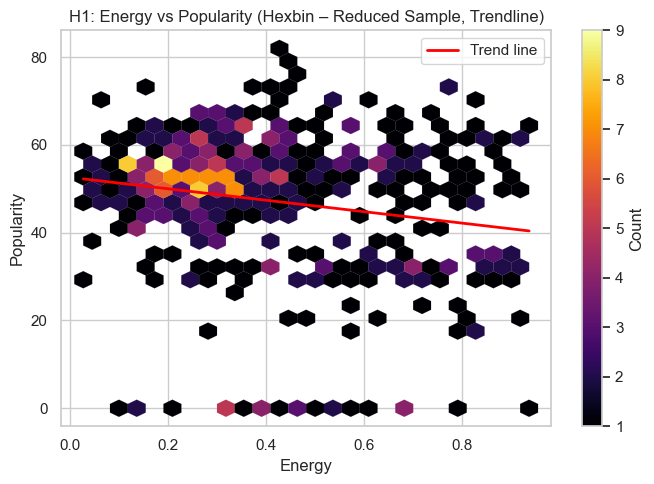

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# (A) Seaborn: Correlation Heatmap (Popularity vs Audio Features)


heat_features = [c for c in ["popularity", "danceability", "energy", "valence", "tempo"]
                 if c in df.columns]

if len(heat_features) >= 2:
    corr_mat = df[heat_features].corr(method="pearson")

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_mat,
        annot=True,          # show numeric correlation values
        fmt=".2f",           # decimal formatting
        vmin=-1, vmax=1,     # full correlation range
        cmap="coolwarm"      # blue → negative, red → positive
    )
    plt.title("H1: Correlations with Popularity (Seaborn Heatmap)")
    plt.tight_layout()
    plt.show()


# (B) Matplotlib: Hexbin + Trend Line (Energy vs Popularity)


if {"energy", "popularity"}.issubset(df.columns):

    # Use first 500 rows for better visibility in dense datasets
    df_subset = df[["energy", "popularity"]].dropna().head(500)

    plt.figure(figsize=(7, 5))

    # Hexbin plot
    hb = plt.hexbin(
        df_subset["energy"],
        df_subset["popularity"],
        gridsize=25,
        mincnt=1,
        cmap="inferno",        # purple → orange continuous spectrum
        linewidths=0.1
    )

    # Trendline (1st-degree polynomial)
    z = np.polyfit(df_subset["energy"], df_subset["popularity"], 1)
    p = np.poly1d(z)

    xs = np.linspace(df_subset["energy"].min(),
                     df_subset["energy"].max(), 100)

    plt.plot(xs, p(xs), color="red", linewidth=2, label="Trend line")

    plt.colorbar(hb, label="Count")
    plt.xlabel("Energy")
    plt.ylabel("Popularity")
    plt.title("H1: Energy vs Popularity (Hexbin – Reduced Sample, Trendline)")
    plt.legend()
    plt.tight_layout()
    plt.show()



H2 - “Explicit tracks are, on average, less popular than clean tracks.”

- We’re comparing average popularity between explicit = True and explicit = False songs.

n_explicit=6950, n_clean=74183
Welch t=16.978, p=1.49e-63
Cohen's d=0.228  (negative means explicit < clean)
mean_explicit=38.68, mean_clean=34.26


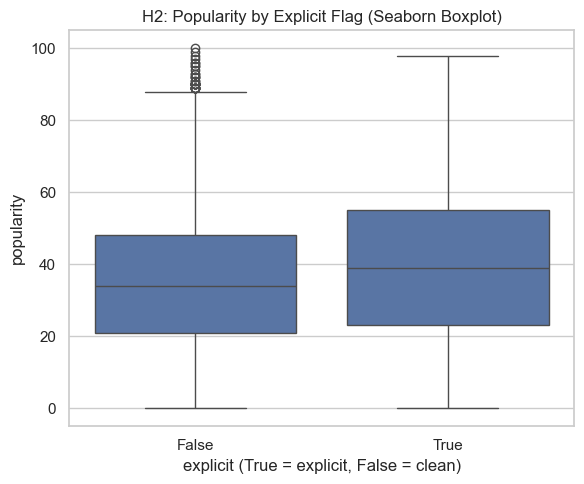

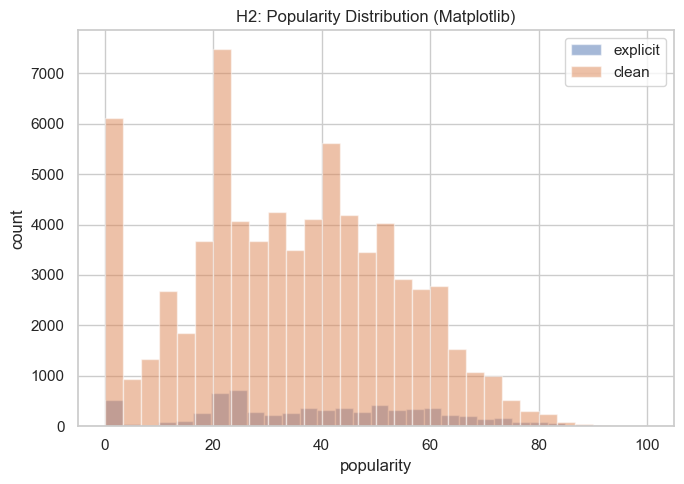

In [18]:
# ============================================================
# H2 - “Explicit tracks are, on average, less popular than clean tracks.”
#
# We compare average popularity between:
#   explicit = True  (explicit tracks)
#   explicit = False (clean tracks)
#
# Statistical tests:
#   - Welch’s t-test (unequal variances)
#   - Cohen’s d (effect size)
#
# Visuals:
#   A. Seaborn boxplot
#   B. Matplotlib histograms
#   C. Plotly violin plot
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px

# (A) Statistical Comparison

if {"explicit", "popularity"}.issubset(df.columns):

    a = df.loc[df["explicit"] == True, "popularity"].dropna()    # explicit
    b = df.loc[df["explicit"] == False, "popularity"].dropna()   # clean

    print(f"n_explicit={len(a)}, n_clean={len(b)}")

    if len(a) > 30 and len(b) > 30:

        # Welch’s t-test
        t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)

        # Cohen’s d (pooled SD)
        pooled_sd = np.sqrt(
            ((a.var(ddof=1) * (len(a) - 1)) +
             (b.var(ddof=1) * (len(b) - 1)))
            / (len(a) + len(b) - 2)
        )
        cohend = (a.mean() - b.mean()) / pooled_sd

        print(f"Welch t={t_stat:.3f}, p={p_val:.3g}")
        print(f"Cohen's d={cohend:.3f}  (negative means explicit < clean)")
        print(f"mean_explicit={a.mean():.2f}, mean_clean={b.mean():.2f}")


    # (B) Visuals

    # --- Boxplot (Seaborn) ---
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df, x="explicit", y="popularity")
    plt.title("H2: Popularity by Explicit Flag (Seaborn Boxplot)")
    plt.xlabel("explicit (True = explicit, False = clean)")
    plt.tight_layout()
    plt.show()

    # --- Histograms (Matplotlib) ---
    plt.figure(figsize=(7, 5))
    plt.hist(a, bins=30, alpha=0.5, label="explicit")
    plt.hist(b, bins=30, alpha=0.5, label="clean")
    plt.xlabel("popularity")
    plt.ylabel("count")
    plt.title("H2: Popularity Distribution (Matplotlib)")
    plt.legend()
    plt.tight_layout()
    plt.show()

#  ---Violin Plotly ---

import nbformat
nbformat.__version__
import plotly.io as pio
pio.renderers.default = "vscode"

fig = px.violin(
    df.dropna(subset=["explicit", "popularity"]),
    x="explicit",
    y="popularity",
    box=True,
    points="all",
    title="H2: Popularity by Explicit Flag (Plotly Violin)"
)
fig.show()


   

H3 - “Popularity peaks near mid-tempo (≈110–130 BPM) and drops at very low/high tempos.”

- We’re checking if tempo has a non-linear relationship with popularity — the “sweet spot” BPM theory.


/var/folders/3h/9x47v4wd4f17sw860nrx9sc00000gn/T/ipykernel_82397/3764375381.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



H3a — Peak median popularity at ~142.5 BPM (median popularity=37.0, n=3732)


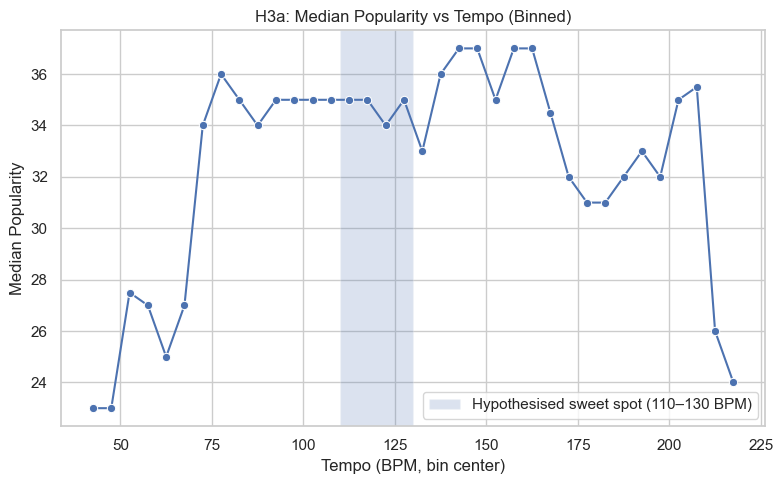

H3b — ANOVA across top genres: F = 743.764, p = 0


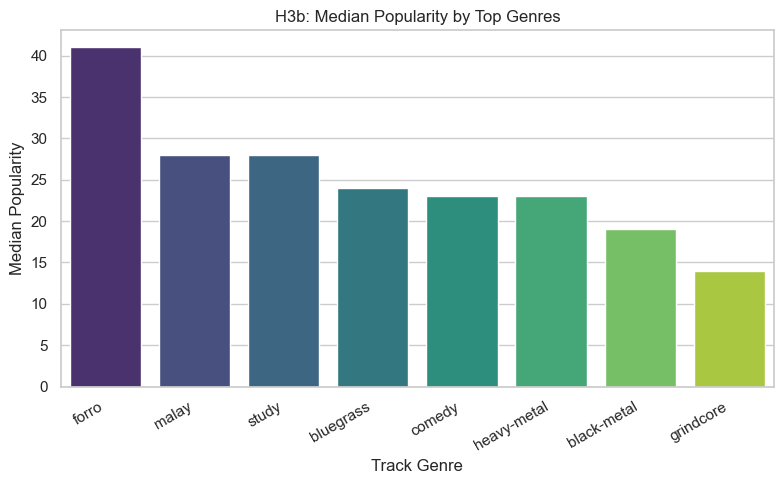

In [17]:
# --- H3: Popularity vs Tempo + Genres & Trends ---


# H3a: "Popularity peaks near mid-tempo (≈110–130 BPM)"

if {"tempo", "popularity"}.issubset(df.columns):
    dft = df[["tempo", "popularity"]].dropna().copy()

    # Keep only reasonable human-tempo values
    dft = dft[(dft["tempo"] >= 40) & (dft["tempo"] <= 220)]

    # Bin tempo into 5 BPM bins and compute median popularity
    tempo_bins = np.arange(40, 225, 5)  # 40–220 by 5 BPM
    dft["tempo_bin"] = pd.cut(dft["tempo"], bins=tempo_bins)

    tempo_stats = (
        dft.groupby("tempo_bin")["popularity"]
        .agg(["median", "mean", "count"])
        .reset_index()
    )

    # Get bin centers for plotting
    tempo_stats["tempo_center"] = tempo_stats["tempo_bin"].apply(lambda x: x.mid)

    # Find peak median popularity BPM
    if len(tempo_stats) > 0:
        peak_row = tempo_stats.loc[tempo_stats["median"].idxmax()]
        print(
            f"H3a — Peak median popularity at ~{peak_row['tempo_center']:.1f} BPM "
            f"(median popularity={peak_row['median']:.1f}, n={int(peak_row['count'])})"
        )

    # PLOT: Median popularity vs tempo (binned)
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=tempo_stats,
        x="tempo_center",
        y="median",
        marker="o",
    )
    plt.axvspan(110, 130, alpha=0.2, label="Hypothesised sweet spot (110–130 BPM)")
    plt.title("H3a: Median Popularity vs Tempo (Binned)")
    plt.xlabel("Tempo (BPM, bin center)")
    plt.ylabel("Median Popularity")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("H3a skipped: 'tempo' and/or 'popularity' columns not found in df.")


# H3b: "Do genres differ in median popularity?"

if {"track_genre", "popularity"}.issubset(df.columns):

    # ---- Select top 8 genres by frequency
    top_genres = df["track_genre"].value_counts().head(8).index.tolist()

    # Filter dataset to just those genres
    dfg = df[df["track_genre"].isin(top_genres)].dropna(subset=["popularity"]).copy()

   
    # H3b: ANOVA across genres
  
    groups = [dfg.loc[dfg["track_genre"] == g, "popularity"].values for g in top_genres]

    if all(len(g) > 30 for g in groups):
        f_stat, p_val = stats.f_oneway(*groups)
        print(f"H3b — ANOVA across top genres: F = {f_stat:.3f}, p = {p_val:.3g}")
    else:
        print(
            "H3b — Not enough data per genre for robust ANOVA; "
            "showing visuals only."
        )

    # VISUAL — Median Popularity by Genre (Seaborn)
    plt.figure(figsize=(8, 5))
    med_pop = (
        dfg.groupby("track_genre")["popularity"]
        .median()
        .sort_values(ascending=False)
    )

    sns.barplot(
        x=med_pop.index,
        y=med_pop.values,
        hue=med_pop.index,   # avoids FutureWarning
        dodge=False,
        legend=False,
        palette="viridis",
    )
    plt.title("H3b: Median Popularity by Top Genres")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Median Popularity")
    plt.xlabel("Track Genre")
    plt.tight_layout()
    plt.show()

    
